In [1]:
using GrootSim

using CSV
using DataFrames
using Dates
using DotEnv
DotEnv.load!()
using PyPlot
using SimpleHypergraphs
using Statistics

using PyCall
pickle = pyimport("pickle");

#### Loading the data

In [2]:
datapath = ENV["DATA_PATH"]
data_to_include_path = ENV["DATA_TO_INCLUDE_PATH"];

In [3]:
# * loading the data
# subreddit_dirs = readdir(thread_basepath)
reddittors_to_include = Set(pickle.load(open(joinpath(data_to_include_path, "final_users_to_include.pkl"))))
subs_to_include = (pickle.load(open(joinpath(data_to_include_path, "final_subs_to_include.pkl"))))
subs_to_include = Set([sub_id[4:end] for sub_id in subs_to_include]);

#### Finding $\Delta$

In [5]:
response_time_per_subthread, delays_per_subthread = eval_response_delay_distribution_across_threads(
    datapath,
    subs_to_include,
    reddittors_to_include
);

subreddit_name: AskReddit
subreddit_name: California
subreddit_name: bayarea
subreddit_name: collapse
subreddit_name: news
subreddit_name: politics


In [6]:
delays = collect(Iterators.flatten(values(delays_per_subthread)))
# convert the delays (ms) to minutes
delays = map(d -> round(d.value/60000), delays)
# convert the delays (mins) to hours
delays_h = map(d -> (d/60), delays);

In [7]:
quantile(delays, [0.25,0.5,0.75])
quantile(delays_h, [0.25,0.5,0.75,0.85,0.93])

5-element Vector{Float64}:
  0.35
  1.8333333333333333
  6.3
 10.166666666666666
 16.983000000000178

In [8]:
# removing outliers
delays_h = delays_h[delays_h .< 7]
mean(delays_h)

1.7397509911161273

In [9]:
quantile(delays_h, [0.25,0.5,0.75])

3-element Vector{Float64}:
 0.21666666666666667
 0.9333333333333333
 2.816666666666667

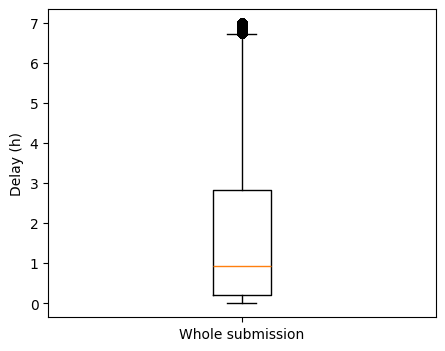

In [10]:
# plot the distribution of the delays
# visualizing them in a boxplot
clf()

#set fig size
fig = figure(figsize=(5,4))

boxplot(delays_h)
ylabel("Delay (h)")
xticks([1], ["Whole submission"])
gcf()

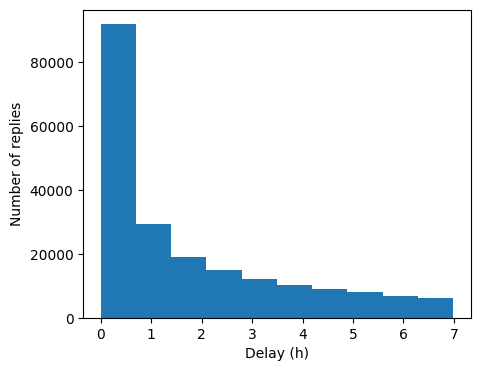

In [11]:
# plot the distribution of the delays
# via a histogram
clf()
hist(delays_h) 
xlabel("Delay (h)")
ylabel("Number of replies")
gcf()

#### Users density (i.e., nodes)

In [4]:
# Here, we consider a time interval of 24 hours over the first year of the dataset
Δₕ = Dates.Hour(24)
Δ = convert(Dates.Millisecond, Dates.Hour(24))
mindate = Dates.DateTime(2020, 07, 1, 0, 0, 0)
maxdate = Dates.DateTime(2022, 12, 31, 0, 0, 0);

In [5]:
# how many different users have posted in each interval?
users_per_interval = eval_users_density_across_threads(
    datapath,
    subs_to_include,
    reddittors_to_include,
    mindate,
    maxdate, 
    Δ;
    normalized=true
);


subreddit_name: AskReddit
subreddit_name: California
subreddit_name: bayarea
subreddit_name: collapse
subreddit_name: news
subreddit_name: politics


In [6]:
n_intervals = length(users_per_interval)
x_val = collect(range(1, length=n_intervals))
y_val_u = [users_per_interval[i] for i in 1:n_intervals]
;

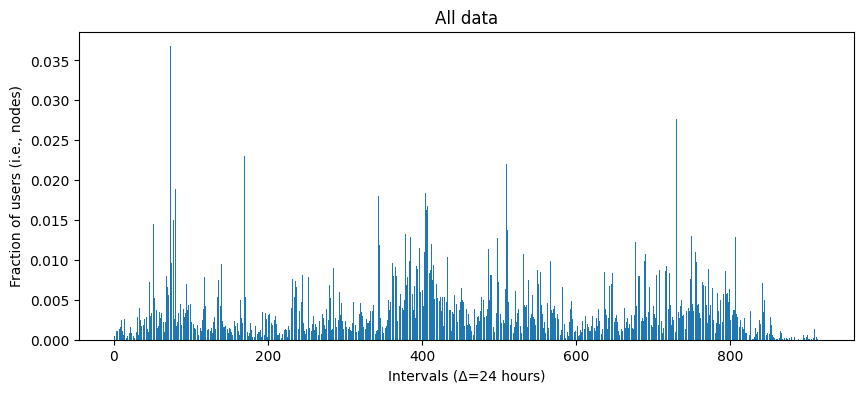

In [7]:
fig = figure(figsize=(10,4))

clf()
bar(x_val, y_val_u)
xlabel("Intervals (Δ=$(Δₕ))")
ylabel("Fraction of users (i.e., nodes)")
title("All data")
gcf()

#### Subthreads density (i.e., hyperedges)

In [5]:
# how many different thread do we have in each interval?
subthreads_per_interval = eval_threads_density_across_threads(
    datapath,
    subs_to_include,
    reddittors_to_include,
    mindate,
    maxdate, 
    Δ;
    normalized=true
);

subreddit_name: AskReddit
subreddit_name: California
subreddit_name: bayarea
subreddit_name: collapse
subreddit_name: news
subreddit_name: politics


In [8]:
n_intervals = length(subthreads_per_interval)
x_val = collect(range(1, length=n_intervals))
y_val_t = [subthreads_per_interval[i] for i in 1:n_intervals]
;

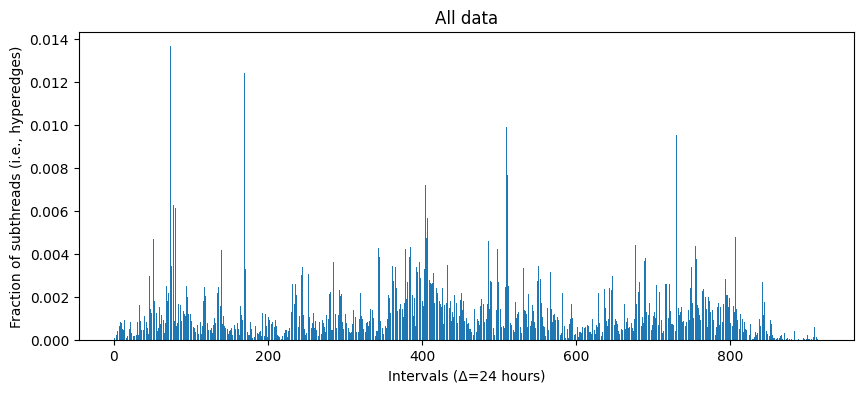

In [9]:
fig = figure(figsize=(10,4))

clf()
bar(x_val, y_val_t)
xlabel("Intervals (Δ=$(Δₕ))")
ylabel("Fraction of subthreads (i.e., hyperedges)")
title("All data")
gcf()

#### Comments density (i.e., action considered)

In [8]:
comments_per_interval = eval_comments_density_across_threads(
    datapath,
    subs_to_include,
    reddittors_to_include,
    mindate,
    maxdate, 
    Δ;
    normalized=true
)

subreddit_name: AskReddit
subreddit_name: California
subreddit_name: bayarea
subreddit_name: collapse
subreddit_name: news
subreddit_name: politics


Dict{Int64, Union{Float64, Int64}} with 914 entries:
  719 => 0.000838947
  858 => 2.83189e-5
  699 => 0.000555758
  831 => 9.91161e-5
  673 => 0.000414164
  73  => 0.00395402
  319 => 0.00100532
  251 => 0.00075753
  687 => 0.000693813
  115 => 0.000651334
  112 => 0.00076461
  185 => 0.000704432
  823 => 0.000930983
  420 => 0.00181241
  525 => 0.0011363
  365 => 0.00253808
  584 => 0.000580537
  638 => 0.00131683
  86  => 0.000541599
  ⋮   => ⋮

In [9]:
n_intervals = length(comments_per_interval)
x_val = collect(range(1, length=n_intervals))
y_val_c = [comments_per_interval[i] for i in 1:n_intervals]
;

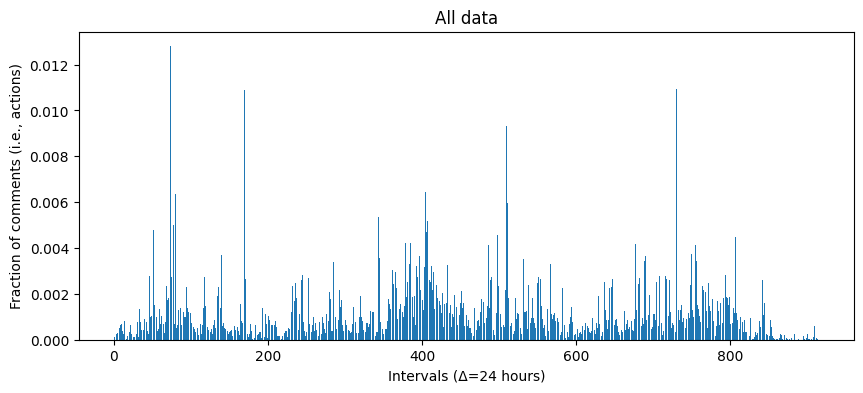

In [10]:
fig = figure(figsize=(10,4))

clf()
bar(x_val, y_val_c)
xlabel("Intervals (Δ=$(Δₕ))")
ylabel("Fraction of comments (i.e., actions)")
title("All data")
gcf()